# 0 Setup environment

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
#import dill

# loading and saving jupyter session
#load_session = True
#save_session = True

# using collab

#path_to_load_session = '/content/drive/My Drive/envs/last_env.db'

#path_to_save_session = 'lorenz_forecasting_env.db'

#if load_session:
#    dill._dill._reverse_typemap['ClassType'] = type
#    dill.load_session(path_to_load_session)

In [2]:
from collections import defaultdict
import numpy as np
import pdb
import random
from sklearn.datasets import make_blobs
from itertools import combinations, product
from scipy.special import gamma
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform, euclidean
import matplotlib.pyplot as plt
from sklearn import datasets
from tqdm import tqdm
from math import sqrt
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import f1_score, confusion_matrix, silhouette_score, davies_bouldin_score
import seaborn as sn

In [3]:
# data generation 

N = 5
WINDOW_MIN = 8
WINDOW = 15

TRAIN_SIZE = 5000
VAL_SIZE = 200
TEST_SIZE = 200
PTS = 100

train_start = 0
train_end = TRAIN_SIZE

val_init = TRAIN_SIZE + WINDOW - 1
val_start = val_init - 1
val_end = val_start + VAL_SIZE

test_init = val_end + WINDOW - 1
test_start = test_init - 1
test_end = test_start + TEST_SIZE - WINDOW

# clusterize data

WISHART_K = 4
WISHART_H = 0.2

# generate predictions

STEPS, EPS = 100, 0.05
# STEPS, EPS = 60, 0.025

Q_VALUE = 0.99


# 1 Functions part

## lorenz series

In [4]:
class Lorentz:
    def __init__(self, s = 10, r = 28, b = 8/3):
        self.s = s
        self.r = r
        self.b = b

    #Differential equations of a Lorenz System
    def X(self, x, y, s):
        return s * (y - x)

    def Y(self, x, y, z, r):
        return (-x) * z + r * x - y

    def Z(self, x, y, z, b):
        return x * y - b * z

    #RK4 for the differential equations
    def RK4(self, x, y, z, s, r, b, dt):
        k_1 = self.X(x, y, s)
        l_1 = self.Y(x, y, z, r)
        m_1 = self.Z(x, y, z, b)

        k_2 = self.X((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), s)
        l_2 = self.Y((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), (z + m_1 * dt * 0.5), r)
        m_2 = self.Z((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), (z + m_1 * dt * 0.5), b)

        k_3 = self.X((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), s)
        l_3 = self.Y((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), (z + m_2 * dt * 0.5), r)
        m_3 = self.Z((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), (z + m_2 * dt * 0.5), b)

        k_4 = self.X((x + k_3 * dt), (y + l_3 * dt), s)
        l_4 = self.Y((x + k_3 * dt), (y + l_3 * dt), (z + m_3 * dt), r)
        m_4 = self.Z((x + k_3 * dt), (y + l_3 * dt), (z + m_3 * dt), b)

        x += (k_1 + 2 * k_2 + 2 * k_3 + k_4) * dt * (1/6)
        y += (l_1 + 2 * l_2 + 2 * l_3 + l_4) * dt * (1/6)
        z += (m_1 + 2 * m_2 + 2 * m_3 + m_4) * dt * (1/6)

        return (x, y, z)

    def generate(self, dt, steps):
        #Initial values and Parameters
        x_0, y_0, z_0 = 1, 1, 1

        #RK4 iteration
        x_list = [x_0]
        y_list = [y_0]
        z_list = [z_0]

        i = 0

        while i < steps:
            x = x_list[i]
            y = y_list[i]
            z = z_list[i]

            position = self.RK4(x, y, z, self.s, self.r, self.b, dt)

            x_list.append(position[0])
            y_list.append(position[1])
            z_list.append(position[2])

            i += 1

        x_array = np.array(x_list)
        y_array = np.array(y_list)
        z_array = np.array(z_list)

        return x_array, y_array, z_array

## wishart clusterization

In [5]:
def volume(r, m):
    return np.pi ** (m / 2) * r ** m / gamma(m / 2 + 1)

def significant(cluster, h, p):
    max_diff = max(abs(p[i] - p[j]) for i, j in product(cluster, cluster))

    # print(max_diff)
    return max_diff >= h

def partition(dist, l, r, order):
    if l == r:
        return l

    pivot = dist[order[(l + r) // 2]]
    left, right = l - 1, r + 1
    while True:
        while True:
            left += 1
            if dist[order[left]] >= pivot:
                break

        while True:
            right -= 1
            if dist[order[right]] <= pivot:
                break

        if left >= right:
            return right

        order[left], order[right] = order[right], order[left]

def nth_element(dist, order, k):
    l, r = 0, len(order) - 1
    while True:
        if l == r:
            break
        m = partition(dist, l, r, order)
        if m < k:
            l = m + 1
        elif m >= k:
            r = m

def get_clustering(x, k, h, verbose=True):
    n = len(x)
    if isinstance(x[0], list):
        m = len(x[0])
    else:
        m = 1
    dist = squareform(pdist(x))

    dk = []
    for i in range(n):
        order = list(range(n))
        nth_element(dist[i], order, k - 1)
        dk.append(dist[i][order[k - 1]])

    # print(dk)

    p = [k / (volume(dk[i], m) * n) for i in range(n)]

    w = np.full(n, 0)
    completed = {0: False}
    last = 1
    vertices = set()
    for d, i in sorted(zip(dk, range(n))):
        neigh = set()
        neigh_w = set()
        clusters = defaultdict(list)
        for j in vertices:
            if dist[i][j] <= dk[i]:
                neigh.add(j)
                neigh_w.add(w[j])
                clusters[w[j]].append(j)

        vertices.add(i)
        if len(neigh) == 0:
            w[i] = last
            completed[last] = False
            last += 1
        elif len(neigh_w) == 1:
            wj = next(iter(neigh_w))
            if completed[wj]:
                w[i] = 0
            else:
                w[i] = wj
        else:
            if all(completed[wj] for wj in neigh_w):
                w[i] = 0
                continue
            significant_clusters = set(wj for wj in neigh_w if significant(clusters[wj], h, p))
            if len(significant_clusters) > 1:
                w[i] = 0
                for wj in neigh_w:
                    if wj in significant_clusters:
                        completed[wj] = (wj != 0)
                    else:
                        for j in clusters[wj]:
                            w[j] = 0
            else:
                if len(significant_clusters) == 0:
                    s = next(iter(neigh_w))
                else:
                    s = next(iter(significant_clusters))
                w[i] = s
                for wj in neigh_w:
                    for j in clusters[wj]:
                        w[j] = s
    return w

In [6]:
class WishartClusterization(object):
    def __init__(self, k, h):
        self.k = k
        self.h = h
        
    
    def fit(self, x):
        n = len(x)
        if isinstance(x[0], list):
            m = len(x[0])
        else:
            m = 1
        dist = squareform(pdist(x))

        dk = []
        for i in range(n):
            order = list(range(n))
            nth_element(dist[i], order, self.k - 1)
            dk.append(dist[i][order[self.k - 1]])

        # print(dk)

        p = [self.k / (volume(dk[i], m) * n) for i in range(n)]

        w = np.full(n, 0)
        completed = {0: False}
        last = 1
        vertices = set()
        for d, i in sorted(zip(dk, range(n))):
            neigh = set()
            neigh_w = set()
            clusters = defaultdict(list)
            for j in vertices:
                if dist[i][j] <= dk[i]:
                    neigh.add(j)
                    neigh_w.add(w[j])
                    clusters[w[j]].append(j)

            vertices.add(i)
            if len(neigh) == 0:
                w[i] = last
                completed[last] = False
                last += 1
            elif len(neigh_w) == 1:
                wj = next(iter(neigh_w))
                if completed[wj]:
                    w[i] = 0
                else:
                    w[i] = wj
            else:
                if all(completed[wj] for wj in neigh_w):
                    w[i] = 0
                    continue
                significant_clusters = set(wj for wj in neigh_w if significant(clusters[wj], self.h, p))
                if len(significant_clusters) > 1:
                    w[i] = 0
                    for wj in neigh_w:
                        if wj in significant_clusters:
                            completed[wj] = (wj != 0)
                        else:
                            for j in clusters[wj]:
                                w[j] = 0
                else:
                    if len(significant_clusters) == 0:
                        s = next(iter(neigh_w))
                    else:
                        s = next(iter(significant_clusters))
                    w[i] = s
                    for wj in neigh_w:
                        for j in clusters[wj]:
                            w[j] = s
        self.labels_ = w
        return self

## generate cluster centers

In [7]:
from itertools import groupby

def generate_centers(x_trains, WISHART_K=4, WISHART_H=0.2):
    ws = {}
    for pattern, train in x_trains.items():
        ws[pattern] = get_clustering(train, WISHART_K, WISHART_H)

    centers = {}
    
    for pattern, w in ws.items():
        sorted_by_cluster = sorted(range(len(w)), key=lambda x: w[x])
        for wi, cluster in groupby(sorted_by_cluster, lambda x: w[x]):
            cluster = list(cluster)
            center = np.full(N, 0.0)
            for i in cluster:

                center += x_trains[pattern][i]
            centers.setdefault(pattern, []).append(center / len(cluster))

    return centers

## windows functions 

In [8]:
import itertools

def generate_subsequences(window, num, short=False):
    values = list(range(window))
    result = []
    if short:
        for subseq in itertools.combinations(values, num):
            diff = WINDOW - WINDOW_MIN
            result.append(tuple([num + diff for num in subseq]))
    else:
        for subseq in itertools.combinations(values, num):
            result.append(subseq)
    
    return result

## sampling

In [9]:
def str_subseq(subseq):
    if not subseq:
        return '<None>'
    return ','.join(map(str, subseq))

def gen_sample_in_point(values, window, pattern, pos):
    # наложить шаблон 
    if pos - window + 1 + pattern[0] >= 0:
        vals = []
        bad = values[pos] == None
        for j in pattern:
            val = values[pos - window + 1 + j]
            if val == None:
                bad = True
                break
            vals.append(val)
        if bad:
            return None
        vals.append(values[pos])
        return vals
    else:
        return None

def gen_sample_in_point_with_q(values, window, pattern, pos):
    # наложить шаблон 
    if pos - window + 1 + pattern[0] >= 0:
        vals = []
        bad = values[pos][0] == None
        for j in pattern:
            val = values[pos - window + 1 + j]
            if val[0] == None:
                bad = True
                break
            vals.append(val)
        if bad:
            return None
        vals.append(values[pos])
        return vals
    else:
        return None
    
def generate_sample(values, window, pattern, put_none=False):
    result = []
    for i in range(len(values)):
        res = gen_sample_in_point(values, window, pattern, i)
        if res == None:
            if put_none:
                result.append(res)
        else:
            result.append(res)
    return result

def aggr(pts):
    if not pts:
        return None
    sum_weight = sum(map(lambda center: center[1], pts))
    pred = sum(map(lambda center: center[0] * center[1], pts))
    return pred / sum_weight

## errors 

In [10]:
def calc_mae(actual, predictions, step):
    result = 0
    predictable = 0
    for start_point, preds in predictions.items():
        if preds[start_point + step]:
            result += abs(actual[start_point + step] - preds[start_point + step])
            predictable += 1
    if predictable == 0:
        return None
    return result / predictable

def calc_rmse(actual, predictions, step):
    result = 0
    predictable = 0
    for start_point, preds in predictions.items():
        if preds[start_point + step]:
            result += np.square(actual[start_point + step] - preds[start_point + step])
            predictable += 1
    if predictable == 0:
        return None
    return sqrt(result / predictable)

def calc_non_predictable(actual, predictions, step):
    result = 0
    for start_point, preds in predictions.items():
        if not preds[start_point + step]:
            result += 1
    return result / len(predictions) * 100

def calc_predictable(actual, predictions, step):
    result = 0
    for start_point, preds in predictions.items():
        if preds[start_point + step]:
            result += 1
    return result / len(predictions) * 100

def calc_metric_for_steps(actual, predictions, calc_metric):
    result = [None]
    for step in range(1, STEPS + 1):

        result.append(calc_metric(actual, predictions, step))
    return result

def calc_mae_for_steps(actual, predictions):
    return calc_metric_for_steps(actual, predictions, calc_mae)

def calc_rmse_for_steps(actual, predictions):
    return calc_metric_for_steps(actual, predictions, calc_rmse)

def calc_non_predictable_for_steps(actual, predictions):
    return calc_metric_for_steps(actual, predictions, calc_non_predictable)

def calc_predictable_for_steps(actual, predictions):
    return calc_metric_for_steps(actual, predictions, calc_predictable)

## generate predictions

In [11]:
from tqdm import trange, tqdm

def generate_predictions(centers, deamon=None, return_set_pred=False, real_mode='test',
                          EPS=0.05, Q_VALUE=0.99):
    preds = {}
    set_preds = {}

    if real_mode == 'test':
        end_point = val_end
        init_point = test_init
    else:
        end_point = train_end
        init_point = val_init

    for start_point in tqdm(range(PTS)):
        
        # initialize empty
        preds[start_point] = [None] * (start_point + 1)
        if return_set_pred:
            set_preds[start_point] = [None] * (start_point + 1)

        # current window
        wind = list(map(lambda x: (x, 1), xs[end_point + start_point : init_point + start_point]))

        for step in range(1, STEPS + 1):
            x_tests_for_point = {}
            for pattern in patterns:
                
                key = str_subseq(pattern + (WINDOW - 1,)) 
                sample = gen_sample_in_point_with_q(np.concatenate([wind, [(0, 0)]]), 
                                                    WINDOW, pattern, len(wind))
                if not sample:
                    x_tests_for_point[key] = None
                else:
                    x_tests_for_point[key] = sample

            chosen_centers = []
            for pattern, centers_values in centers.items():
                if not x_tests_for_point[pattern]:
                    continue
                vector = np.array(x_tests_for_point[pattern][:-1])[:, 0]
                q_values = np.array(x_tests_for_point[pattern][:-1])[:, 1]

                for center in centers_values:
                    dist = euclidean(vector, center[:-1])
                    if dist < EPS:
                        weight_d = (EPS - dist) / EPS
                        weight_q = np.mean(q_values) * Q_VALUE
                        chosen_centers.append((pattern, center, weight_d, weight_q))

            last_points = list(map(lambda center: (center[1][-1], center[2], center[3], center[0]), 
                                  chosen_centers))
            
            # deamon predict
            result_point = deamon.predict(start_point, step, last_points)
            preds[start_point].append(result_point)

            if return_set_pred:
                set_preds[start_point].append(last_points)

            
            if result_point:
                q_value = np.mean(np.array(list(map(lambda center: center[2], 
                                  chosen_centers))))
            else:
                q_value = None
            
            # move the window
            wind = np.concatenate([wind[1:], [(result_point, q_value)]])

    deamon.predicted = True

    if return_set_pred:
        return preds, set_preds
    return preds

## aggregate predictions with weights

In [12]:
def simple_aggr(pts):
  if not pts:
        return None
  return np.mean(np.array(list(map(lambda center: center[0], pts))))

def aggr_d(pts):
    # weighted sum by distance
    if not pts:
        return None
    sum_weight = sum(map(lambda center: center[1], pts))
    pred = sum(map(lambda center: center[0] * center[1], pts))
    return pred / sum_weight

def aggr_q(pts):
    # weighted sum by q-value
    if not pts:
        return None
    sum_weight = sum(map(lambda center: center[2], pts))
    pred = sum(map(lambda center: center[0] * center[2], pts))
    return pred / sum_weight

def aggr_mix(pts):
    if not pts:
        return None
    sum_weight = sum(map(lambda center: center[1] * center[2], pts))
    pred = sum(map(lambda center: center[0] * center[1] * center[2], pts))
    return pred / sum_weight

## demon metrics visualizion

In [13]:
def add_preds(preds, daemon, filtered_preds):
    preds[daemon] = filtered_preds

def get_metrics(daemons, actual, return_values=False, plot=True):
    preds = {}
    
    for daemon in daemons:
        add_preds(preds, daemon[1], daemon[0].get_predictions())
    
    mae, rmse, non_pred = plot_daemons_result(actual, preds, plot=plot)

    if return_values:
        return mae, rmse, non_pred

def print_metrics_for_subplot(metrics, ax, title):
    for values, label in metrics:
        ax.plot(values[:-1], label=label)
    ax.set_title(title)
    ax.legend(loc='best')
    #ax.set_xticks([1, 5, 10, 15, 20, 25, 30])
    ax.set_xticks(np.arange(0, STEPS + 1, 5))
    ax.grid()

def print_metric_for_subplot(func, metric_name, actual, daemons_predictions, ax, plot=True):
    metrics = []
    for label, pred in daemons_predictions.items():
        metrics.append([func(actual, pred), label])
    if plot:
        print_metrics_for_subplot(metrics, ax, metric_name)

    return metrics

def plot_daemons_result(actual, daemons_predictions, plot=True):
    if plot:
        fig, ax = plt.subplots(2, 2, figsize=(20,10))
        fig.tight_layout()
    else:
        ax = np.zeros((2,2))
    mae = print_metric_for_subplot(calc_mae_for_steps, 'MAE', actual, daemons_predictions, ax[0][0], plot=plot)
    rmse = print_metric_for_subplot(calc_rmse_for_steps, 'RMSE', actual, daemons_predictions, ax[0][1], plot=plot)
    non_pred = print_metric_for_subplot(calc_non_predictable_for_steps, 'non-predictable (%)', actual, daemons_predictions, ax[1][0], plot=plot)
    print_metric_for_subplot(calc_predictable_for_steps, 'predictable (%)', actual, daemons_predictions, ax[1][1], plot=plot)
    if plot:
        plt.show()

    return mae, rmse, non_pred

## divergence visualization

In [31]:
def visualize_point(preds, point, real_vals=x_test, plot_all_points=None, plot_tube_points=None,
                    highlight_point=None, plot_res_tube=None, offset=3):
    plt.figure(figsize=(20, 8))
    colors=['green', 'red', 'orange']

    limits_real = [point - offset, point + STEPS + offset]
    plt.plot(
        range(limits_real[0], limits_real[1]),
        real_vals[limits_real[0]:limits_real[1]], 
        label='real values'
    )

    limits_predictions = [point, point + STEPS]
    for i, pred in enumerate(preds):
        plt.plot(
            range(limits_predictions[0], limits_predictions[1]),
            pred[0].get_predictions()[point][limits_predictions[0]:limits_predictions[1]], 
            label=pred[1], 
            marker='o', 
            markersize=2,
            c=colors[i]
        )

        if plot_all_points:
            for step in plot_all_points:
                raw_preds = pred[0].get_set_predictions()[point][point + step]
                set_preds = list(map(lambda x: x[0], raw_preds))
                plt.scatter([point + step for i in range(len(set_preds))], 
                            set_preds, alpha=0.2, color='red')
    if highlight_point:
        plt.plot(
            point + highlight_point,
            pred[0].get_predictions()[point][point + highlight_point], 
            label='bad', 
            marker='o', 
            markersize=10, 
            color="purple"
        )

    if plot_res_tube is not None:
        plt.plot(range(limits_predictions[0] + 1, limits_predictions[1] + 1), plot_res_tube, label='tube avg')

    if plot_tube_points is not None:
        for tr in plot_tube_points:
            plt.plot(range(limits_predictions[0] + 1, limits_predictions[1] + 1), tr, alpha=0.3, linestyle='--')

    

    plt.scatter([point], real_vals[point], label='start')
    plt.axvline(x=(point + 1), linewidth=0.5, color='r', label="step 1")
    for mark in range(5, STEPS + 1, 5):
        plt.axvline(x=(point + mark), linewidth=0.5, color='r', label="step " + str(mark))

    plt.title("Divergence")
    plt.xlabel("point")
    plt.ylabel("Lorenz value")
    plt.legend()

## histogram utils

In [15]:
def get_weights(start, step, mode, set_preds):
    preds = list(map(lambda x: x[0], set_preds[start][start + step]))
    pred = simple_aggr(set_preds[start][start + step])

    if mode == 'simple':
        weights = np.ones(len(preds))
    elif mode == 'q-value':
        weights = list(map(lambda x: x[2], set_preds[start][start + step]))
    elif mode == 'dist':
        weights = list(map(lambda x: x[1], set_preds[start][start + step]))
    elif mode == 'mix':
        weights = list(map(lambda x: x[1] * x[2], set_preds[start][start + step]))

    return pred, preds, weights

In [16]:
def plot_hist_for_fixed_point(start_point, step, set_preds, y_limit=30):
    fig = plt.figure(figsize=(15, 5))
    modes = ['simple', 'q-value', 'dist', 'mix']
    for i, mode in enumerate(modes):
        ax = fig.add_subplot(2, 2, i + 1)
        pred, preds, weights = get_weights(start_point, step, mode, set_preds)

        vals = ax.hist(preds, weights=weights, bins=100, range=(0, 1), label='preds')
                    
        ax.plot([pred for i in range(2)], [0, y_limit], c='green', label='simple_pred')
        ax.plot([x_test[start_point + step] for i in range(2)], [0, y_limit], c='red', 
                label='real')
        ax.legend(loc='upper left')
        ax.set_title('Mode: ' + mode  + ' || Start:' + str(start_point) + ' || Step ahead:' + str(step))
        ax.set_ylim(0, y_limit)
        
        fig.tight_layout() 

In [17]:
def get_points(step, mae_threshold, predictions):
    good_points = []
    bad_points = []
    for start_point, preds in predictions.items():
        if preds[start_point + step]:
            mae = abs(x_test[start_point + step] - preds[start_point + step])
            if mae > mae_threshold:
                bad_points.append(start_point)
            else:
                good_points.append(start_point)
    return good_points, bad_points

## mode weights

In [18]:
def get_weights(start, step, mode, set_predictions):
    return get_weights_with_preds(set_predictions[start][start + step], mode)

def get_weights_with_preds(set_preds, mode):
    preds = list(map(lambda x: x[0], set_preds))
    pred = simple_aggr(set_preds)

    if mode == 'simple':
        weights = np.ones(len(preds))
    elif mode == 'q-value':
        pred = aggr_q(set_preds)
        weights = list(map(lambda x: x[2], set_preds))
    elif mode == 'dist':
        pred = aggr_d(set_preds)
        weights = list(map(lambda x: x[1], set_preds))
    elif mode == 'mix':
        pred = aggr_mix(set_preds)
        weights = list(map(lambda x: x[1] * x[2], set_preds))

    return pred, preds, weights

## bad points

In [19]:
def find_bad_points(demon):
    good_points = []
    bad_points = []
    labels = []

    for start_point in range(0, PTS):
        for step in range(1, STEPS + 1):
            if demon.get_predictions()[start_point][start_point + step]:
                good_points.append((start_point, step))
            else:
                bad_points.append((start_point, step))

    return good_points, bad_points

## statistic visualization

In [20]:
def convert_features_to_percent(good, bad):
    features = list(good) + list(bad)
    avg = np.mean(features)
    return 100 * (good / avg), 100 * (bad / avg)


def get_avg_with_alpha(stat, alpha=1.0):
    good_features, good_labels, bad_features, bad_labels = get_features_by_stat(stat)
    features = list(good_features) + list(bad_features)

    return np.mean(features) * alpha 

def get_features_by_stat(stat):
    good_features = []
    bad_features = []
    
    good_labels = []
    bad_labels = []

    for start, step in good_points:    
        pred, preds, weights = get_weights(start, step, 'mix', Simple_deamon_mix_val.get_set_predictions())
        hist_vals = np.histogram(preds, weights=weights, bins=100, range=(0, 1))    
        feature = stat.apply(preds, hist_vals)
        good_features.append(feature)
        good_labels.append(1)
    
    for start, step in bad_points:
        pred, preds, weights = get_weights(start, step, 'mix', Simple_deamon_mix_val.get_set_predictions())
        hist_vals = np.histogram(preds, weights=weights, bins=100, range=(0, 1))    
        feature = stat.apply(preds, hist_vals)
        bad_features.append(feature)
        bad_labels.append(0)

    return good_features, good_labels, bad_features, bad_labels

def visualize_stats(stat, bins=None, thr=None):
    good_features, good_labels, bad_features, bad_labels = get_features_by_stat(stat)
    
    good_bad_ratio = int(round(len(bad_points) / len(good_points)))
    good_weights = [good_bad_ratio for _ in range(len(good_features))]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4))

    ax1.set_title("Real " + stat.label() + " values")
    ret1 = ax1.hist(good_features, bins=bins, weights=good_weights, label='good', color='orange')
    ret2 = ax1.hist(bad_features, bins=bins, alpha=0.4, label='bad', color='blue')
    if thr == 0:
        mean = np.mean(np.append(good_features, bad_features))
        max_val = max(np.append(ret1[0] , ret2[0]))
        ax1.plot([mean, mean], [0, max_val], label='threshold', color='red')
    if thr:
        mean = np.mean(np.append(good_features, bad_features))
        thr_1 = mean + thr * mean
        max_val = max(np.append(ret1[0] , ret2[0]))
        ax1.plot([mean, mean], [0, max_val], label='mean', color='green')
        ax1.plot([thr_1, thr_1], [0, max_val], label='threshold', color='red')
    ax1.legend()

    good_percent_features, bad_percent_features = convert_features_to_percent(good_features, bad_features)

    ax2.set_title(stat.label() + " values converted percent of AVG")
    ret1 = ax2.hist(good_percent_features, bins=bins, weights=good_weights, label='good', color='orange')
    ret2 = ax2.hist(bad_percent_features, bins=bins, alpha=0.4, label='bad', color='blue')
    if thr == 0:
        mean = np.mean(np.append(good_percent_features, bad_percent_features))
        max_val = max(np.append(ret1[0] , ret2[0]))
        ax2.plot([mean, mean], [0, max_val], label='threshold', color='red')
    if thr:
        mean = np.mean(np.append(good_percent_features, bad_percent_features))
        thr_2 = mean + thr * mean
        max_val = max(np.append(ret1[0] , ret2[0]))
        ax2.plot([mean, mean], [0, max_val], label='mean', color='green')
        ax2.plot([thr_2, thr_2], [0, max_val], label='threshold', color='red')
    ax2.legend()

    plt.show()

    if thr == 0:
        return  np.mean(np.append(good_features, bad_features))
        
    if thr:
        return thr_1

## correlation visualization

In [21]:
import seaborn as sns

def visualize_correlation(stats):
    fig = plt.figure(figsize=(10, 10))
        
    data = {stat.label() : [] for stat in stats}
    data['label'] = []

    for start, step in good_points:
        pred, preds, weights = get_weights(start, step, 'mix', Simple_deamon_mix_val.get_set_predictions())
        hist_vals = np.histogram(preds, weights=weights, bins=100, range=(0, 1))  

        for stat in stats:
            data[stat.label()].append(stat.apply(preds, hist_vals))
        data['label'].append(1)

    for start, step in bad_points: 
        pred, preds, weights = get_weights(start, step, 'mix', Simple_deamon_mix_val.get_set_predictions())
        hist_vals = np.histogram(preds, weights=weights, bins=100, range=(0, 1))    

        for stat in stats:
            data[stat.label()].append(stat.apply(preds, hist_vals))
        data['label'].append(0)

    df = pd.DataFrame(data, columns=data.keys())
    corrMatrix = df.corr()

    sns.heatmap(corrMatrix, annot=True)

## bad points coverage

In [22]:
def check_bad_points_coverage(demon):
    ideal_coverage = 0
    demon_coverage = 0

    for start_point, step in bad_points:
        if not Ideal_deamon.predictions[start_point][start_point + step]:
            ideal_coverage += 1
        if not demon.predictions[start_point][start_point + step]:
            demon_coverage += 1

    print(demon.label + " coverage", str(int(100 * demon_coverage / len(bad_points))) + "%", sep=' ')        
    print("Ideal coverage", str(int(100 * ideal_coverage / len(bad_points)))  + "%", sep=' ')        

## plot confusion matrix

In [23]:
def get_confusion_matrix(demon_1, demon_2):
    points = []

    for start_point in range(0, PTS):
        for step in range(1, STEPS + 1):
            label_1 = 1 if demon_1[0].get_predictions()[start_point][start_point + step] else 0
            label_2 = 1 if demon_2[0].get_predictions()[start_point][start_point + step] else 0
            points.append([start_point, step, label_1, label_2])
    df = pd.DataFrame(points, columns=['start_point', 'step', demon_1[1], demon_2[1]])
    conf_mat = confusion_matrix(df[demon_2[1]], df[demon_1[1]])

    print("F1-score: ", f1_score(df[demon_2[1]], df[demon_1[1]]))

    conf_mat = np.array(conf_mat) / np.sum(conf_mat)

    plt.figure(figsize=(8, 5))
    ax = plt.axes()
    sn.heatmap(conf_mat, annot=True, ax=ax)
    ax.set_title('Confusion matrix')
    ax.set_xlabel(demon_1[1])
    ax.set_ylabel(demon_2[1])
    plt.show()

## get values via ind

In [24]:
def get_values(raw_vals, ind=0):
    return list(map(lambda x: x[ind], raw_vals))

## get metrics for clustering

In [25]:
def find_params_for_clustering(clst, par_1_set, par_2_set):
    silhouette = []
    davies_bouldin = []
    
    for point in range(PTS):
        for step in range(1, STEPS + 1):
            raw_values = Simple_deamon_mix_val.get_set_predictions()[point][point + step]
            if isinstance(clst, WishartClusterization):
                values = np.array(np.unique(get_values(raw_values)))
            else:
                values = np.array(get_values(raw_values))
            clusters = clst.fit(values.reshape(-1, 1))

            if len(np.unique(clusters.labels_)) > 1:
                silhouette.append(silhouette_score(values.reshape(-1, 1), clusters.labels_))
                davies_bouldin.append(davies_bouldin_score(values.reshape(-1, 1), clusters.labels_))

    return (np.mean(silhouette), np.mean(davies_bouldin))

def get_cluster_metrics(par_1_set, par_2_set, clastering='DBSCAN'):
    result = {}

    for par_1 in par_1_set:
            for par_2 in par_2_set:
                if clastering == 'DBSCAN':
                    clst = DBSCAN(eps=par_1, min_samples=par_2)
                else:
                    clst = WishartClusterization(k=par_1, h=par_2)
                metrics = find_params_for_clustering(clst, par_1_set, par_2_set)
                result[str(par_1) + ' ' + str(par_2)] = metrics
    return result

# 2 Initial research


## generate lorenz

In [26]:
xs, _, _ = Lorentz().generate(0.1, 100000)
xs = (xs - xs.min()) / (xs.max() - xs.min())

In [27]:
x_train = xs[train_start:train_end]
x_val = xs[val_start:val_end]
x_test = xs[test_start:test_end]

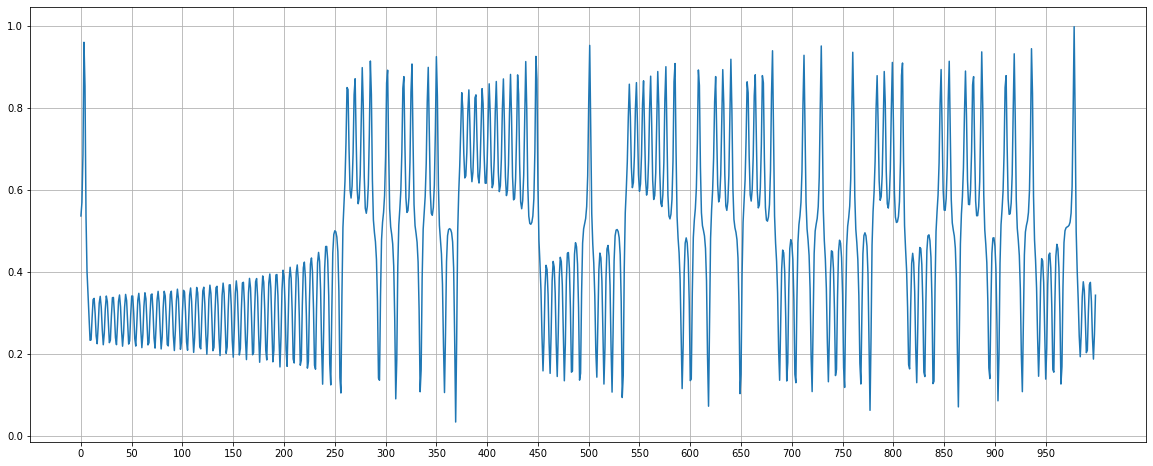

In [28]:
plt.figure(figsize=(20, 8))
plt.plot(xs[:1000])
plt.xticks([i for i in range(0, 1000, 50)])
plt.grid()
plt.show()

## generate data


In [29]:
def generate_patterns():
    patterns1 = generate_subsequences(WINDOW_MIN - 1, N - 1, short=True)
    patterns2 = generate_subsequences(WINDOW - 1, N - 1)
    
    patterns3 = random.choices(patterns2[300:], k=35)
    
    return patterns1 + patterns3

In [30]:
x_trains = {}
patterns = generate_patterns()

for pattern in patterns:
    key = str_subseq(pattern + (WINDOW - 1,))
    
    x_trains[key] = generate_sample(x_train, WINDOW, pattern, put_none=False)

## clusterize train data

In [32]:
%%time

centers = generate_centers(x_trains)

CPU times: user 14min 46s, sys: 5.51 s, total: 14min 52s
Wall time: 14min 53s


## demons approximation

### Simple deamon

In [33]:
class SimpleDeamon(object):
    def __init__(self, mode='simple'):
        self.mode = mode
        self.predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        self.set_predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}

        self.predicted = False
        
    @property
    def label(self):
        return 'Simple model of demon with ' + self.mode + ' mode'

    def predict(self, start_point, step, preds):
        self.set_predictions[start_point].append(preds)

        if self.mode == 'simple':
            pred = simple_aggr(preds)
        elif self.mode == 'd_weighted':
            pred = aggr_d(preds)
        elif self.mode == 'q_weighted':
            pred = aggr_q(preds)
        elif self.mode == 'mix':
            pred = aggr_mix(preds)

        self.predictions[start_point].append(pred)
        return pred
    
    def get_predictions(self):
        return self.predictions
    
    def get_set_predictions(self):
        return self.set_predictions

    def is_predicted(self):
        return self.predicted

### Ideal approximation

In [34]:
class IdealDeamon(object):
    def __init__(self, eps=0.05, mode='simple', real_vals=x_test):
        self.eps = eps
        self.mode = mode 
        self.real_vals=real_vals
        self.predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        self.set_predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        
    @property
    def label(self):
        return 'Ideal model of demon'

    def predict(self, start_point, step, preds):
        self.set_predictions[start_point].append(preds)
        pred, _, _ = get_weights(start_point, step, self.mode, self.set_predictions)
        if not pred or abs(pred - self.real_vals[start_point + step]) > self.eps:
            pred = None

        self.predictions[start_point].append(pred)
        return pred
    
    def get_predictions(self):
       return self.predictions
    
    def get_set_predictions(self):
       return self.set_predictions

### Difference between min max 

In [35]:
class MinMaxDeamon(object):
    def __init__(self, eps, aggr_func=simple_aggr):
        self.eps = eps
        self.aggr_func = aggr_func
        self.predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        self.set_predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        
    @property
    def label(self):
        return 'Set difference between min max ' + str(self.eps)
    
    def predict(self, start_point, step, preds):
        self.set_predictions[start_point].append(preds)
        if not preds:
            pred = None
        else:
            sorted_preds = sorted(preds, key=lambda pred: pred[0], reverse=True)
            if abs(sorted_preds[0][0] - sorted_preds[-1][0]) < self.eps:
                pred = self.aggr_func(preds)
            else:
                pred = None
        
        self.predictions[start_point].append(pred)
        return pred 
    
    def get_predictions(self):
       return self.predictions
    
    def get_set_predictions(self):
       return self.set_predictions

## generate predictions

### validation

In [36]:
Simple_deamon_val = SimpleDeamon(mode='simple')
Ideal_deamon_val = IdealDeamon(real_vals=x_val)

deamons = [
           Simple_deamon_val,
           Ideal_deamon_val
]

for deamon in deamons:
    generate_predictions(centers, deamon=deamon, real_mode='val')

100%|██████████| 100/100 [06:47<00:00,  4.07s/it]


### test

In [37]:
Simple_deamon_test = SimpleDeamon(mode='simple')
Ideal_deamon_test = IdealDeamon()

deamons = [
           Simple_deamon_test,
           Ideal_deamon_test,
]

for deamon in deamons:
    generate_predictions(centers, deamon=deamon, return_set_pred=False)

100%|██████████| 100/100 [06:29<00:00,  3.90s/it]


## visualize metrics

### validation

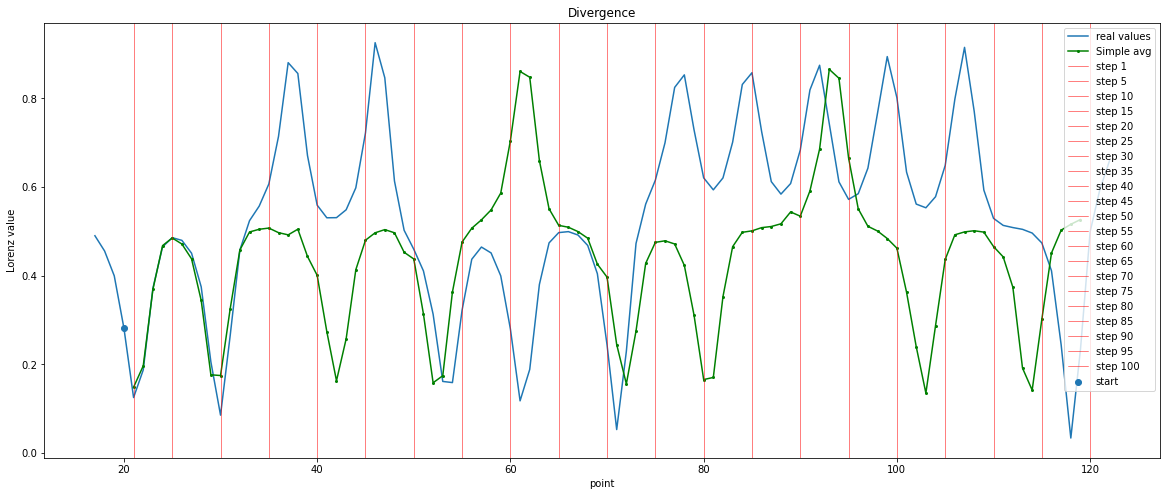

In [38]:
visualize_point([
                 (Simple_deamon_val, 'Simple avg')], 
                20,
                real_vals=x_val
                )

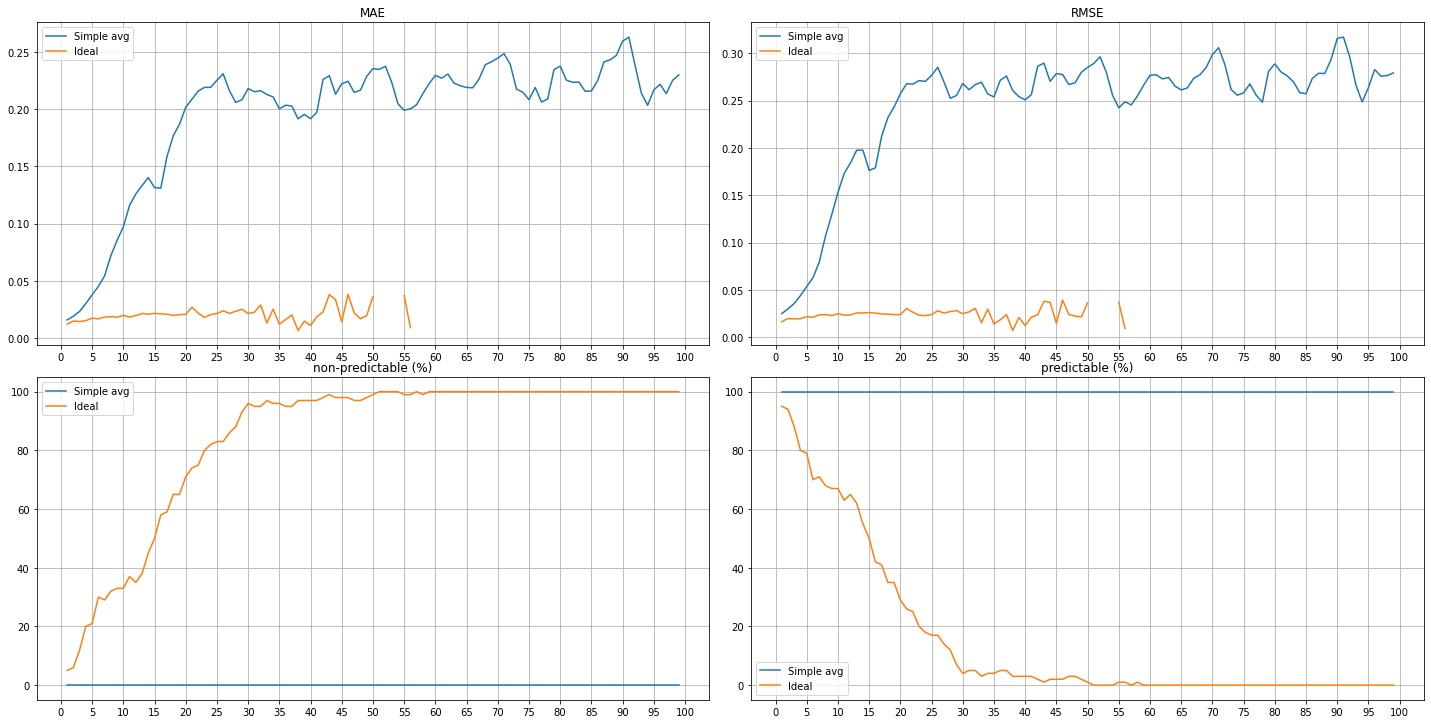

In [39]:
deamons = [
           (Simple_deamon_val, "Simple avg"),
           (Ideal_deamon_val, "Ideal")
]

get_metrics(deamons, x_val)

### test

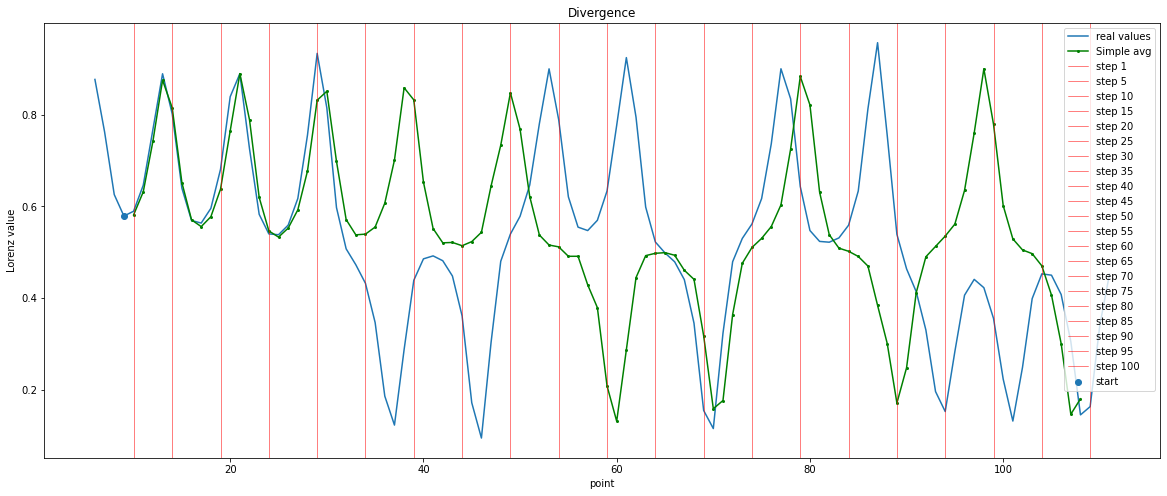

In [40]:
visualize_point([
                 (Simple_deamon_test, 'Simple avg')], 
                9
                )

IndexError: index 185 is out of bounds for axis 0 with size 185

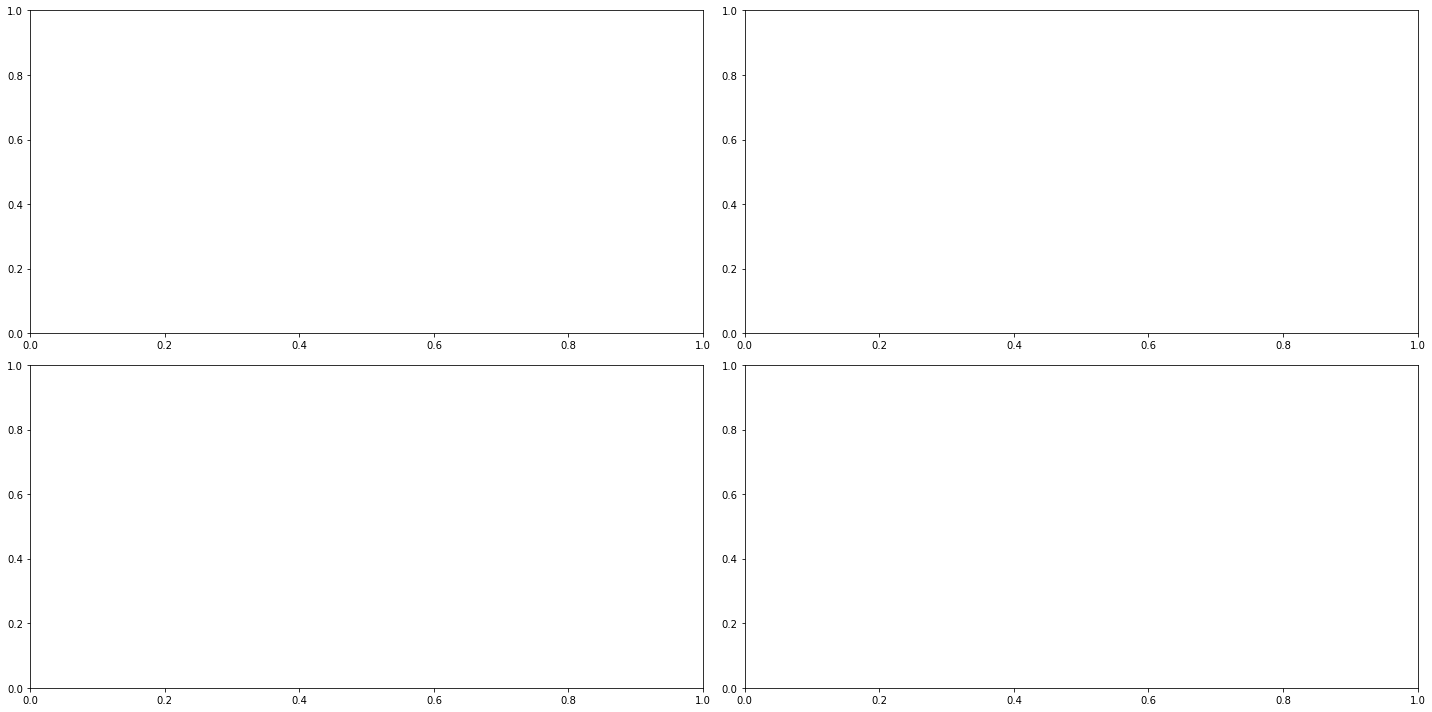

In [41]:
deamons = [
           (Simple_deamon_test, "Simple avg"),
           (Ideal_deamon_test, "Ideal")
]

get_metrics(deamons, x_test)

## play with h clusterizaion 

In [42]:
h_set = [0.04, 1]

centers_set = []
for h in h_set:
    centers_set.append(generate_centers(x_trains, WISHART_H=h))

In [43]:
demons_set = []
for h in h_set:
    demons_set.append(SimpleDeamon(mode='simple'))

for i, demon in enumerate(demons_set):
    generate_predictions(centers_set[i], deamon=demon, real_mode='val')

100%|██████████| 100/100 [50:56<00:00, 30.56s/it]


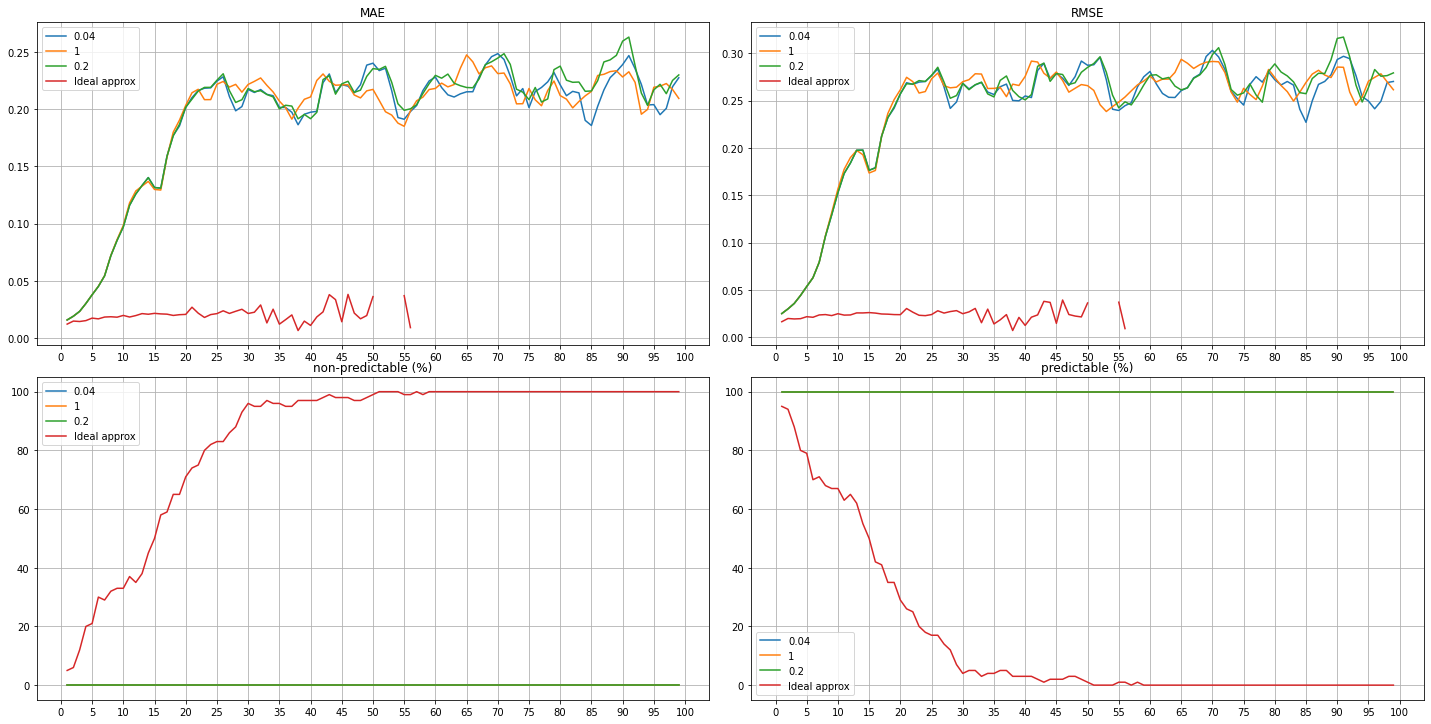

In [44]:
demons = []

for i, demon in enumerate(demons_set):
    demons.append((demon, str(h_set[i])))

demons.append((Simple_deamon_val, "0.2"))
demons.append((Ideal_deamon_val, "Ideal approx"))

get_metrics(demons, x_val)

## play with q weight

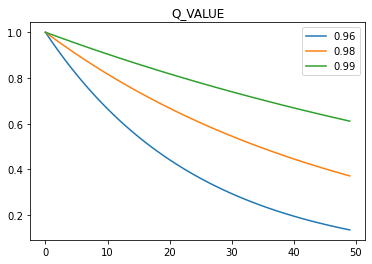

In [45]:
plt.title("Q_VALUE")

q_set = [0.96, 0.98, 0.99]

for q in q_set:
    plt.plot([q**i for i in range(0, 50)], label=str(q))
plt.legend()

In [46]:
demons_set = []
for q in q_set:
    demons_set.append(SimpleDeamon(mode='q_weighted'))

for i, demon in enumerate(demons_set):
    generate_predictions(centers, deamon=demon, real_mode='val', Q_VALUE=q)

100%|██████████| 100/100 [50:59<00:00, 30.59s/it]


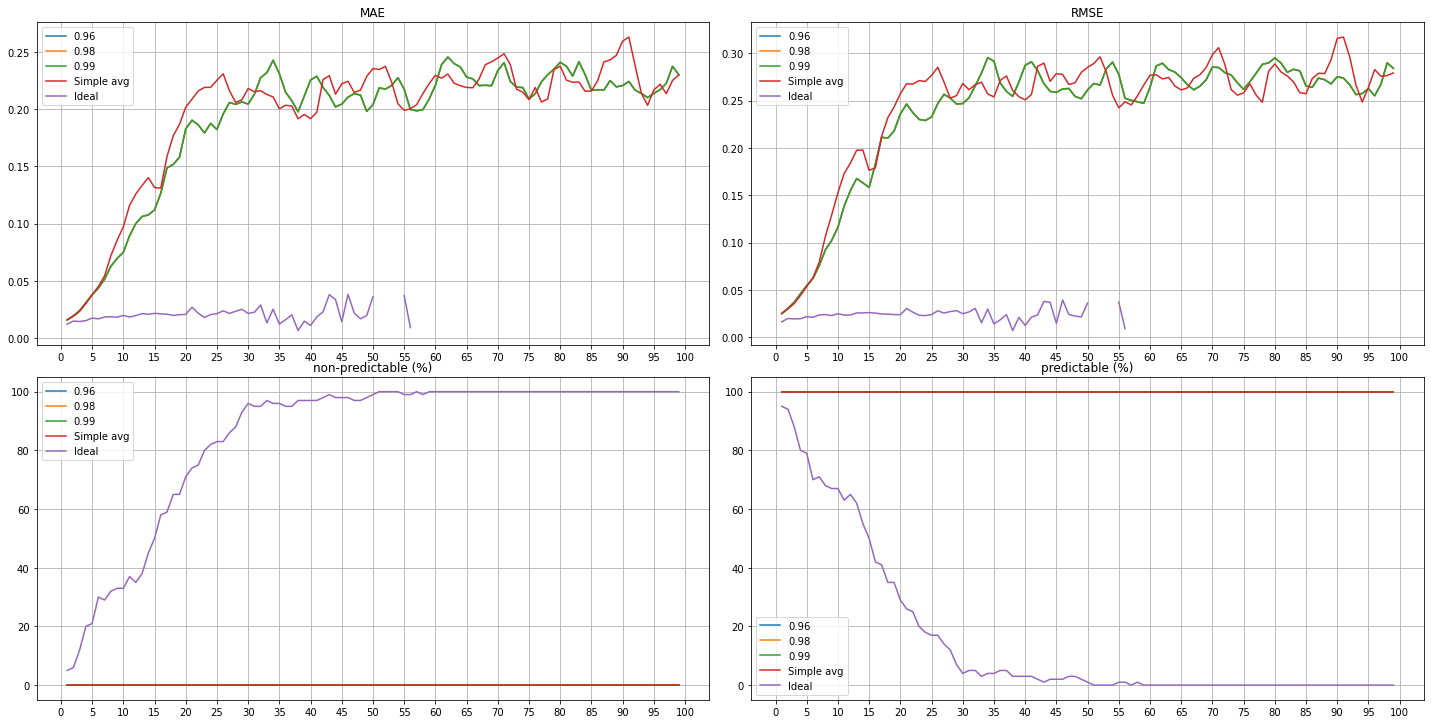

In [47]:
demons = []

for i, demon in enumerate(demons_set):
    demons.append((demon, str(q_set[i])))

demons.append((Simple_deamon_val, "Simple avg"))
demons.append((Ideal_deamon_val, "Ideal"))

get_metrics(demons, x_val)

## play with min_max

In [ ]:
min_max_set = [0.05, 0.2, 0.5]

demons_set = []
for min_max in min_max_set:
    demons_set.append(MinMaxDeamon(min_max))

for i, demon in enumerate(demons_set):
    generate_predictions(centers, deamon=demon, real_mode='val')

 93%|█████████▎| 93/100 [05:39<00:37,  5.38s/it]

In [ ]:
demons = []

for i, demon in enumerate(demons_set):
    demons.append((demon, str(min_max_set[i])))

demons.append((Simple_deamon_val, "Simple demon"))
demons.append((Ideal_deamon_val, "Ideal approx"))

get_metrics(demons, x_test)

## play with modes

In [ ]:
Simple_deamon_d_val = SimpleDeamon(mode='d_weighted')
Simple_deamon_q_val = SimpleDeamon(mode='q_weighted')
Simple_deamon_mix_val = SimpleDeamon(mode='mix')

demons_set = [
           Simple_deamon_d_val,
           Simple_deamon_q_val,
           Simple_deamon_mix_val
]

for demon in demons_set:
    generate_predictions(centers, deamon=demon, real_mode='val')

In [ ]:
demons = []

demons.append((Ideal_deamon_val, "Ideal"))
demons.append((Simple_deamon_val, "Simple avg"))
demons.append((Simple_deamon_d_val, "d-avg"))
demons.append((Simple_deamon_q_val, "q-avg"))
demons.append((Simple_deamon_mix_val, "mix-avg"))
#demons.append((MinMax_deamon, "min max"))

get_metrics(demons, x_val)

### mix on validation

In [ ]:
demons = []

demons.append((Ideal_deamon_val, "Ideal"))
demons.append((Simple_deamon_val, "Simple avg"))
demons.append((Simple_deamon_mix_val, "Mix avg"))
#demons.append((MinMax_deamon, "min max"))

get_metrics(demons, x_val)

### mix on test

In [ ]:
demons = []

demons.append((Ideal_deamon_test, "Ideal"))
demons.append((Simple_deamon_test, "Simple avg"))
demons.append((Simple_deamon_mix_test, "Mix avg"))
#demons.append((MinMax_deamon, "min max"))

get_metrics(demons, x_test)

# 3 Distribution experiment 

## Simple and ideal mix-mode on val

In [ ]:
demons = []

demons.append((Ideal_deamon_mix_val, "Ideal mix-avg"))
demons.append((Simple_deamon_mix_val, "Mix avg"))
#demons.append((MinMax_deamon, "min max"))

get_metrics(demons, x_val)


## find bad points

In [ ]:
good_points, bad_points = find_bad_points(Ideal_deamon_mix_val) 

good_bad_ratio = int(round(len(bad_points) / len(good_points)))

In [ ]:
print("good points count", len(good_points))
print("bad points count", len(bad_points))

print("bad/good point ratio", good_bad_ratio)

### Simple mix val

In [ ]:
bad = bad_points[2174]
print("example of bad point", bad)

visualize_point([
                (Simple_deamon_mix_val, 'Mix avg')], 
                bad[0],
                real_vals=x_val,
                highlight_point=bad[1]
                )

### Ideal mix val

In [ ]:
visualize_point([
                (Ideal_deamon_mix_val, 'Ideal avg')], 
                bad[0],
                real_vals=x_val
                )

## try statistics

### Mode count 



In [ ]:
class Multimode_Stat(object):
    def __init__(self, par=0.2):
        self.par = par 
    
    def label(self):
        return "Multimode, par=" + str(self.par)

    def apply(self, preds, hist_vals):
        mode_num = max(hist_vals[0])
        return len(list(filter(lambda val: val >= mode_num * self.par, hist_vals[0])))

In [ ]:
visualize_stats(Multimode_Stat(0.2))

In [ ]:
visualize_stats(Multimode_Stat(0.4))

In [ ]:
visualize_stats(Multimode_Stat(0.6))

### Difference between percentiles

In [ ]:
class PercentDiff_Stat(object):
    def __init__(self, par_left=0, par_right=100):
        self.par_left = par_left
        self.par_right = par_right 
    
    def label(self):
        return "Diff " + str(self.par_right) + " and " +  str(self.par_left) + " perc"

    def apply(self, preds, hist_vals):
        right_border = np.percentile(preds, self.par_right)
        left_border = np.percentile(preds, self.par_left)
        return abs(right_border - left_border)

In [ ]:
visualize_stats(PercentDiff_Stat(par_left=0, par_right=100))

In [ ]:
visualize_stats(PercentDiff_Stat(par_left=20, par_right=80))

In [ ]:
visualize_stats(PercentDiff_Stat(par_left=40, par_right=60))

In [ ]:
visualize_stats(PercentDiff_Stat(par_left=10, par_right=90))

### Moments

In [ ]:
from scipy.stats import moment

def weighted_mom(values, weights, par):
    m = np.average(values, weights=weights)
    var = np.average((values - m)**par, weights=weights)
    return var * 1000

class Moment_Stat(object):
    def __init__(self, par=3):
        self.par = par
    
    def label(self):
        return str(self.par) + " moment" 

    def apply(self, preds, hist_vals):
        probs = hist_vals[0] / sum(hist_vals[0])
        values = hist_vals[1]

        return weighted_mom(values[1:], probs, self.par)

In [ ]:
visualize_stats(Moment_Stat(par=2))

In [ ]:
visualize_stats(Moment_Stat(par=3))

In [ ]:
visualize_stats(Moment_Stat(par=4))

### Entropy


In [ ]:
from scipy.stats import entropy

class Entropy(object):
    def __init__(self):
        pass
    
    def label(self):
        return "Entropy"

    def apply(self, preds, hist_vals):
        probs = hist_vals[0] / sum(hist_vals[0])
        return entropy(probs)

In [ ]:
visualize_stats(Entropy())

### Kurtosis

In [ ]:
from scipy.stats import kurtosis

class Kurtosis_Stat(object):
    def __init__(self):
        pass
    
    def label(self):
        return "Kurtosis" 

    def apply(self, preds, hist_vals):
        return kurtosis(hist_vals[0])

In [ ]:
visualize_stats(Kurtosis_Stat())

## correlation matrix

In [ ]:
stats = [
         Multimode_Stat(par=0.2),
         Multimode_Stat(par=0.4),
         Multimode_Stat(par=0.6),
         Multimode_Stat(par=0.8),
         PercentDiff_Stat(par_left=0, par_right=100),
         PercentDiff_Stat(par_left=20, par_right=80),
         PercentDiff_Stat(par_left=40, par_right=60),
         Moment_Stat(par=2),
         Moment_Stat(par=3),
         Moment_Stat(par=4),
         Entropy(),
         Kurtosis_Stat()
]

In [ ]:
visualize_correlation(stats)

## the best stat

In [ ]:
thr = visualize_stats(Entropy(), thr=-0.1)
ent_thr_1 = (-0.1, thr)

In [ ]:
thr = visualize_stats(Entropy(), thr=-0.05)
ent_thr_2 = (-0.05, thr)

In [ ]:
thr = visualize_stats(Entropy(), thr=0)
ent_thr_3 = (0, thr)

In [ ]:
thr = visualize_stats(Entropy(), thr=0.05)
ent_thr_4 = (0.05, thr)

In [ ]:
thr = visualize_stats(Entropy(), thr=0.1)
ent_thr_5 = (0.1, thr)

# 4 Clustering experiment

## take a look on points

In [ ]:
visualize_point([
                 (Simple_deamon_mix_val, 'Mix avg')
                ], 
                17,
                real_vals=x_val,
                plot_all_points=[i for i in range(1, STEPS +1)]
)

## find best params

In [ ]:
eps_dbscan = [0.001, 0.003, 0.005, 0.007, 0.009, 0.01]
min_samples_dbscan =  [3, 4, 5, 6, 8]

result_dbscan = get_cluster_metrics(eps_dbscan, min_samples_dbscan)

In [ ]:
k_wishart = [3, 5, 8, 11, 13]
h_wishart = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

result_wishart = get_cluster_metrics(k_wishart, h_wishart, clastering='Wishart')

In [ ]:
result_dbscan

In [ ]:
result_wishart

## try clusters stats

### Clusters amount

In [ ]:
class ClustersAmount_stat(object):
    def __init__(self, model=DBSCAN(eps=0.01, min_samples=3)):
        self.model = model
    
    def label(self):
        if isinstance(self.model, WishartClusterization):
            return "Amount of clusters Wishart" 
        return "Amount of clusters"

    def apply(self, preds, hist_vals):
        if isinstance(self.model, WishartClusterization):
            values = np.array(np.unique(preds))
            if len(values) == 2:
                if abs(values[0] - values[1]) <= 0.001:
                    return 1
                return 2
        else:
            values = np.array(preds)
        
        if len(values) == 1:
            return 1

        clusters = self.model.fit(values.reshape(-1, 1))
        return len(np.unique(clusters.labels_[clusters.labels_ != -1]))

In [ ]:
visualize_stats(ClustersAmount_stat())

In [ ]:
visualize_stats(ClustersAmount_stat(WishartClusterization(3, 0.1)))

### Percent of max cluster

In [ ]:
class ClustersPerc_stat(object):
    def __init__(self, model=DBSCAN(eps=0.01, min_samples=3)):
        self.model = model
    
    def label(self):
        if isinstance(self.model, WishartClusterization):
            return "Percent of max cluster Wishart" 
        return "Percent of max cluster" 

    def apply(self, preds, hist_vals):
        if isinstance(self.model, WishartClusterization):
            values, counts_values = np.unique(preds, return_counts=True)
        
        else:
            counts_values = np.ones(len(preds))
            values = np.array(preds)

        clusters = self.model.fit(values.reshape(-1, 1))

        labels = []
        for i in range(len(counts_values)):
            if clusters.labels_[i] != -1: 
                for j in range(int(counts_values[i])):
                    labels.append(clusters.labels_[i])

        _, counts_clusters = np.unique(labels, return_counts=True)

        return 100 * max(counts_clusters) / len(preds)

In [ ]:
visualize_stats(ClustersPerc_stat(), bins=30)

In [ ]:
visualize_stats(ClustersPerc_stat(WishartClusterization(3, 0.1)), bins=30)

### Difference between max and min cluster

In [ ]:
class MinMaxClusterDiff_stat(object):
    def __init__(self, model=DBSCAN(eps=0.01, min_samples=3)):
        self.model = model
    
    def label(self):
        if isinstance(self.model, WishartClusterization):
            return "Min Max cluster diff Wishart" 
        return "Min Max cluster diff"

    def apply(self, preds, hist_vals):
        if isinstance(self.model, WishartClusterization):
            values, counts_values = np.unique(preds, return_counts=True)
        
        else:
            counts_values = np.ones(len(preds))
            values = np.array(preds)

        clusters = self.model.fit(values.reshape(-1, 1))

        labels = []
        for i in range(len(counts_values)):
            if clusters.labels_[i] != -1: 
                for j in range(int(counts_values[i])):
                    labels.append(clusters.labels_[i])
        
        _, counts_clusters = np.unique(labels, return_counts=True)

        return 100 * (max(counts_clusters) - min(counts_clusters)) / len(preds)

In [ ]:
visualize_stats(MinMaxClusterDiff_stat(), bins=30)

In [ ]:
visualize_stats(MinMaxClusterDiff_stat(WishartClusterization(3, 0.1)), bins=30)

## correlation matrix

In [ ]:
stats = [
        ClustersAmount_stat(),
        ClustersAmount_stat(WishartClusterization(3, 0.1)),
        ClustersPerc_stat(),
        ClustersPerc_stat(WishartClusterization(3, 0.1)),
        MinMaxClusterDiff_stat(),
        MinMaxClusterDiff_stat(WishartClusterization(3, 0.1))
]

In [ ]:
visualize_correlation(stats)

## the best stat

### Amount of clusters DBSCAN

In [ ]:
thr = visualize_stats(ClustersAmount_stat(), thr=-0.1)
cluster_thr_1 = (-0.1, thr)

In [ ]:
thr = visualize_stats(ClustersAmount_stat(), thr=0)
cluster_thr_2 = (0, thr)

In [ ]:
thr = visualize_stats(ClustersAmount_stat(), thr=0.1)
cluster_thr_3 = (0.1, thr)

### Amount of clusters Wishart

### Percent of max xluster

# 5 Filter predictions

## filter demon

In [ ]:
class FilterBasedOnStatDemon(object):
    def __init__(self, stat, stat_threshold):
        self.predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        self.set_predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}

        self.predicted = False

        self.stat = stat
        self.stat_threshold = stat_threshold
        
    @property
    def label(self):
        return self.stat.label()

    def predict(self, start_point, step, preds):
        self.set_predictions[start_point].append(preds)

        pred, stat_preds, weights = get_weights_with_preds(preds, 'mix')
        hist_vals = np.histogram(stat_preds, weights=weights, bins=100, range=(0, 1))  

        if stat_preds:
            feature = self.stat.apply(stat_preds, hist_vals)

            if feature <= self.stat_threshold:
                pred = pred
            else:
                pred = None
        else:
            pred = None 

        self.predictions[start_point].append(pred)
        return pred
    
    def get_predictions(self):
        return self.predictions
    
    def get_set_predictions(self):
        return self.set_predictions

    def is_predicted(self):
        return self.predicted

## check best stats

### Entropy

#### Validation

In [ ]:
thrs = [ent_thr_1, ent_thr_2, ent_thr_3, ent_thr_4, ent_thr_5]
demons_ent = []

for thr in thrs:
    demons_ent.append((FilterBasedOnStatDemon(Entropy(), stat_threshold=thr[1]), str(thr[0])))


for demon in demons_ent:
    generate_predictions(centers, deamon=demon[0], real_mode='val')

In [ ]:
demons_ent.append((Simple_deamon_mix_val, "Mix avg"))
demons_ent.append((Ideal_deamon_val, "Ideal"))

get_metrics(demons_ent, x_val)

#### best

In [ ]:
get_metrics([
             demons_ent[0],
             demons_ent[-2],
             demons_ent[-1]
], x_val)

In [ ]:
deamon_check = (demons_ent[0][0], 'Entropy filter')
ideal = (Ideal_deamon_val, 'ideal')
get_confusion_matrix(deamon_check, ideal)

#### test

In [ ]:
ent_demon = FilterBasedOnStatDemon(Entropy(), stat_threshold=ent_thr_1[1])
generate_predictions(centers, deamon=ent_demon)
print()

In [ ]:
get_metrics([
             (Simple_deamon_mix_test, 'Mix avg'),
             (Ideal_deamon_test, 'Ideal'),
             (ent_demon, 'entropy filter')
], x_test)

In [ ]:
deamon_check = (ent_demon, 'Entropy filter')
ideal = (Ideal_deamon_test, 'ideal')
get_confusion_matrix(deamon_check, ideal)

### Cluster amount

In [ ]:
thrs = [cluster_thr_1, cluster_thr_2, cluster_thr_3]
demons_cluster = []

for thr in thrs:
    demons_cluster.append((FilterBasedOnStatDemon(ClustersAmount_stat(), stat_threshold=thr[1]), str(thr[0])))


for demon in demons_cluster:
    generate_predictions(centers, deamon=demon[0], real_mode='val')

In [ ]:
demons_cluster.append((Simple_deamon_mix_val, "Mix avg"))
demons_cluster.append((Ideal_deamon_val, "Ideal"))

get_metrics(demons_cluster, x_val)

### best

In [ ]:
get_metrics([
             demons_cluster[2],
             demons_cluster[-2],
             demons_cluster[-1]
], x_val)

In [ ]:
deamon_check = (demons_cluster[0][0], 'Cluster filter')
ideal = (Ideal_deamon_val, 'ideal')
get_confusion_matrix(deamon_check, ideal)

# 6 ML experiment

## make features

### choose stats

In [ ]:
stats = [
         Multimode_Stat(par=0.2),
         PercentDiff_Stat(par_left=20, par_right=80),
         Moment_Stat(par=2),
         Entropy(),
         Kurtosis_Stat(),
         ClustersAmount_stat(),
         ClustersAmount_stat(WishartClusterization(3, 0.1)),
         ClustersPerc_stat(),
         ClustersPerc_stat(WishartClusterization(3, 0.1))
]

In [ ]:
visualize_correlation(stats)

In [ ]:
lin_stats = [
              Multimode_Stat(par=0.2),
              Moment_Stat(par=2),
              ClustersAmount_stat(WishartClusterization(3, 0.1))
        ]

In [ ]:
all_stats = [
             Multimode_Stat(par=0.2),
             Moment_Stat(par=2),
             PercentDiff_Stat(par_left=20, par_right=80),
             Entropy(),
             Kurtosis_Stat(),
             ClustersAmount_stat()
]

### generate features

In [ ]:
def get_features_for_clf(stats):
    good_features = []
    bad_features = []

    good_labels = []
    bad_labels = []


    for start, step in good_points:    
        pred, preds, weights = get_weights(start, step, 'mix', Simple_deamon_mix_val.get_set_predictions())
        hist_vals = np.histogram(preds, weights=weights, bins=100, range=(0, 1))    
        cur_feat = []
        for stat in stats:
            cur_feat.append(stat.apply(preds, hist_vals))
        good_features.append(cur_feat)
        good_labels.append(1)

    for start, step in bad_points:
        pred, preds, weights = get_weights(start, step, 'mix', Simple_deamon_mix_val.get_set_predictions())
        hist_vals = np.histogram(preds, weights=weights, bins=100, range=(0, 1))    
        cur_feat = []
        for stat in stats:
            cur_feat.append(stat.apply(preds, hist_vals))
        bad_features.append(cur_feat)
        bad_labels.append(0)

    return good_features + bad_features, good_labels + bad_labels


X_lin, y_lin = get_features_for_clf(lin_stats)

X, y = get_features_for_clf(all_stats)

### normalize

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def scale(X):
    scaler = MinMaxScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler

X_lin, lin_scaler = scale(X_lin)
X, scaler = scale(X)

### solve imbalance

In [ ]:
y.count(1)

In [ ]:
y.count(0)

In [ ]:
from imblearn.over_sampling import SMOTE

def data_balance(X, y):
    sm = SMOTE()
    X_res, y_res = sm.fit_resample(X, y)
    return X_res, y_res

X_lin, y_lin = data_balance(X_lin, y_lin)
X, y = data_balance(X, y)

### check classifiers

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(X_lin, y_lin, test_size=0.1)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

def fit_clf(clf, features, labels):
    return clf.fit(features, labels)

def greed_search(clf, params, X_train, X_test, y_train, y_test):
    gs_clf = GridSearchCV(estimator=clf, 
                          param_grid=params,
                          scoring='f1',
                          cv=10,
                          n_jobs=-1)
    gs_clf.fit(X_train, y_train)
    best_clf = gs_clf.best_estimator_
    y_pred = best_clf.predict(X_test)

    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("F1-score: ", f1_score(y_test, y_pred))
    print("Best params: ", gs_clf.best_params_)
    return best_clf

def check_clf(clf, params, X_train, X_test, y_train, y_test):
    print(clf[1])
    best_clf = greed_search(clf[0], params, X_train, X_test, y_train, y_test)
    return best_clf

In [ ]:
all_params = [
              {'C' : [1e-2, 1e-1, 1]},
              {'C' : [1e-2, 1e-1, 1, 10],
               'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']},
              {'criterion' : ['gini', 'entropy'],
               'max_depth': [None, 2, 4, 6, 8]},
              {'n_neighbors' : [3, 5, 7],
               'weights' : ['uniform', 'distance']},
              {'hidden_layer_sizes' : [(8,),(16,), (32,), (64, 32), 
                                       (64, 32, 16), (128, 64, 32, 16)],
               'activation' : ['logistic']}
]

classifiers = [
               (LogisticRegression(), 'logreg'),
               (SVC(), 'svm'),
               (DecisionTreeClassifier(), 'decision tree'),
               (KNeighborsClassifier(), 'knn'),
               (MLPClassifier(), 'mlp')
]

best_classifiers = []

for i, clf in enumerate(classifiers):
    if clf[1] == 'logreg':
        cur_clf = check_clf(clf, all_params[i], X_train_lin, X_test_lin, y_train_lin, y_test_lin)
    else:
        cur_clf = check_clf(clf, all_params[i], X_train, X_test, y_train, y_test)
    best_classifiers.append((cur_clf, clf[1]))
    print()

## Filter demon

In [ ]:
class MLDemon(object):
    def __init__(self, clf, stats, scaler, ensemble=False):
        self.predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        self.set_predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        self.clf = clf
        self.stats = stats
        self.scaler = scaler
        self.ensemble = ensemble
        
    @property
    def label(self):
        return self.stat.label()

    def predict(self, start_point, step, preds):
        self.set_predictions[start_point].append(preds)
        if not preds:
            pred = None 
            self.predictions[start_point].append(pred)
            return pred
        
        pred, preds, weights = get_weights(start_point, step, 'mix', self.set_predictions)
        hist_vals = np.histogram(preds, weights=weights, bins=100, range=(0, 1)) 

        features = []
        for stat in self.stats:
            features.append(stat.apply(preds, hist_vals))
        
        features = self.scaler.transform([features])
        
        if self.ensemble:

            votes = [c.predict(features) for c in clf]

            if np.mean(votes) <= 0.5:
                pred = None 
                self.predictions[start_point].append(pred)
                return pred
        else:
            if not self.clf.predict(features):
                pred = None 
                self.predictions[start_point].append(pred)
                return pred
        
        self.predictions[start_point].append(pred)
        return pred
    
    def get_predictions(self):
        return self.predictions
    
    def get_set_predictions(self):
        return self.set_predictions

### Simple models

In [ ]:
demons_ml = []

for clf in best_classifiers:
    if clf[1] == 'logreg':
        trained_clf = clf[0].fit(X_lin, y_lin)
        ml_demon = MLDemon(clf=trained_clf, stats=lin_stats, scaler=lin_scaler)
    else:
        trained_clf = clf[0].fit(X, y)
        ml_demon = MLDemon(clf=trained_clf, stats=all_stats, scaler=scaler)
    generate_predictions(centers, deamon=ml_demon, real_mode='test')
    demons_ml.append((ml_demon, clf[1]))
    print()

#### simple models results

In [ ]:
demons_ml.append((Simple_deamon_mix_test, "Mix avg"))
demons_ml.append((Ideal_deamon_test, "Ideal"))

get_metrics(demons_ml, x_test)

In [ ]:
def highlight_max(s):
    is_max = s == s[~np.isnan(s)].min()
    return ['color: red' if v else 'color: black' for v in is_max]


def error_table_per_step(demons, steps=[1] + [i for i in range(5, 51, 5)]):
    mae_res = [[round(get_metrics([demon], x_test, return_values=True, plot=False)[0][0][0][i], 3) if get_metrics([demon], x_test, return_values=True, plot=False)[0][0][0][i] != None else None for i in steps] for demon in demons]
    rmse_res = [[round(get_metrics([demon], x_test, return_values=True, plot=False)[1][0][0][i], 3) if get_metrics([demon], x_test, return_values=True, plot=False)[1][0][0][i] != None else None for i in steps] for demon in demons]
    non_pred_res = [[int(get_metrics([demon], x_test, return_values=True, plot=False)[2][0][0][i]) for i in steps] for demon in demons]
    inds = [demon[1] + ' filter' for demon in demons]

    df_mae = pd.DataFrame(data=mae_res, index=inds, columns=steps)
    df_mae = df_mae.style.highlight_min()

    df_rmse = pd.DataFrame(data=rmse_res, index=inds, columns=steps)
    df_rmse = df_rmse.style.highlight_min()

    df_non_pred = pd.DataFrame(data=non_pred_res, index=inds, columns=steps)
    df_non_pred = df_non_pred.style.highlight_min()
    return df_mae, df_rmse, df_non_pred

In [ ]:
df_mae, df_rmse, df_non_pred = error_table_per_step(demons_ml[:-2])

In [ ]:
df_mae

In [ ]:
df_rmse

In [ ]:
df_non_pred

##### logreg

In [ ]:
get_metrics([
             demons_ml[0],
             demons_ml[-2],
             demons_ml[-1]
], x_test)

In [ ]:
deamon_check = (demons_ml[0][0], 'logreg filter')
ideal = (Ideal_deamon_test, 'ideal')

get_confusion_matrix(deamon_check, ideal)

In [ ]:
visualize_point([(Simple_deamon_mix_test, 'Mix avg'),
                 (demons_ml[0][0], demons_ml[0][1] + ' filter')
                 ],
                93, 
                real_vals=x_test
                )

##### svm

In [ ]:
get_metrics([
             demons_ml[1],
             demons_ml[-2],
             demons_ml[-1]
], x_test)

In [ ]:
deamon_check = (demons_ml[1][0], 'SVM filter')
ideal = (Ideal_deamon_test, 'ideal')

get_confusion_matrix(deamon_check, ideal)

In [ ]:
visualize_point([(Simple_deamon_mix_test, 'Mix avg'),
                 (demons_ml[1][0], demons_ml[1][1] + ' filter')
                 ],
                93, 
                real_vals=x_test
                )

##### decision tree

In [ ]:
get_metrics([
             demons_ml[2],
             demons_ml[-2],
             demons_ml[-1]
], x_test)

In [ ]:
deamon_check = (demons_ml[2][0], 'decision tree filter')
ideal = (Ideal_deamon_test, 'ideal')

get_confusion_matrix(deamon_check, ideal)

In [ ]:
visualize_point([(Simple_deamon_mix_test, 'Mix avg'),
                 (demons_ml[2][0], demons_ml[2][1] + ' filter')
                 ],
                93, 
                real_vals=x_test
                )

##### knn

In [ ]:
get_metrics([
             demons_ml[3],
             demons_ml[-2],
             demons_ml[-1]
], x_test)

In [ ]:
deamon_check = (demons_ml[3][0], 'knn filter')
ideal = (Ideal_deamon_test, 'ideal')

get_confusion_matrix(deamon_check, ideal)

In [ ]:
visualize_point([(Simple_deamon_mix_test, 'Mix avg'),
                 (demons_ml[3][0], demons_ml[3][1] + ' filter')
                 ],
                93, 
                real_vals=x_test
                )

##### mlp

In [ ]:
get_metrics([
             demons_ml[4],
             demons_ml[-2],
             demons_ml[-1]
], x_test)

In [ ]:
deamon_check = (demons_ml[4][0], 'mlp filter')
ideal = (Ideal_deamon_test, 'ideal')

get_confusion_matrix(deamon_check, ideal)

In [ ]:
visualize_point([(Simple_deamon_mix_test, 'Mix avg'),
                 (demons_ml[4][0], demons_ml[4][1] + ' filter')
                 ],
                93, 
                real_vals=x_test
                )

### ensemble models

#### ada boost

In [ ]:
ensemble_demons = []

for clf in classifiers:
    if clf[1] == 'knn' or clf[1] == 'mlp':
        continue
    if clf[1] == 'logreg':
        trained_clf = AdaBoostClassifier(base_estimator=clf[0], algorithm='SAMME').fit(X_lin, y_lin)
        ml_demon = MLDemon(clf=trained_clf, stats=lin_stats, scaler=lin_scaler)
    else:
        trained_clf = AdaBoostClassifier(base_estimator=clf[0], algorithm='SAMME').fit(X, y)
        ml_demon = MLDemon(clf=trained_clf, stats=all_stats, scaler=scaler)
    generate_predictions(centers, deamon=ml_demon, real_mode='test')
    ensemble_demons.append((ml_demon, 'ada boost ' + clf[1]))
    print()

In [ ]:
get_metrics([
             ensemble_demons[0],
             (Simple_deamon_mix_test, 'Mix avg'),
             (Ideal_deamon_test, 'Ideal')
], x_test)

In [ ]:
visualize_point([(Simple_deamon_mix_test, 'Mix avg'),
                 ensemble_demons[0]
                 ],
                93, 
                real_vals=x_test
                )

In [ ]:
deamon_check = ensemble_demons[0]
ideal = (Ideal_deamon_test, 'ideal')

get_confusion_matrix(deamon_check, ideal)

In [ ]:
get_metrics([
             ensemble_demons[1],
             (Simple_deamon_mix_test, 'Mix avg'),
             (Ideal_deamon_test, 'Ideal')
], x_test)

In [ ]:
visualize_point([(Simple_deamon_mix_test, 'Mix avg'),
                 ensemble_demons[1]
                 ],
                93, 
                real_vals=x_test
                )

In [ ]:
deamon_check = ensemble_demons[1]
ideal = (Ideal_deamon_test, 'ideal')

get_confusion_matrix(deamon_check, ideal)

In [ ]:
get_metrics([
             ensemble_demons[2],
             (Simple_deamon_mix_test, 'Mix avg'),
             (Ideal_deamon_test, 'Ideal')
], x_test)

In [ ]:
deamon_check = ensemble_demons[2]
ideal = (Ideal_deamon_test, 'ideal')

get_confusion_matrix(deamon_check, ideal)

#### stacking

In [ ]:
from sklearn.ensemble import StackingClassifier

classifiers_1 = [
               ('logreg', best_classifiers[0][0]),
               ('svm', best_classifiers[1][0]),
               #('decision tree', DecisionTreeClassifier()),
               #('knn', KNeighborsClassifier()),
               ('mlp', best_classifiers[4][0])
]

clf = StackingClassifier(estimators=classifiers_1[1:]).fit(X, y)
stacking_demon = MLDemon(clf=clf, stats=all_stats, scaler=scaler)
generate_predictions(centers, deamon=stacking_demon, real_mode='test')
stacking_demon = (stacking_demon, 'stacking')
print()

In [ ]:
get_metrics([
             stacking_demon,
             (Simple_deamon_mix_test, 'Mix avg'),
             (Ideal_deamon_test, 'Ideal')
], x_test)

In [ ]:
deamon_check = stacking_demon
ideal = (Ideal_deamon_test, 'ideal')

get_confusion_matrix(deamon_check, ideal)

In [ ]:
visualize_point([(Simple_deamon_mix_test, 'Mix avg'),
                 stacking_demon
                 ],
                93, 
                real_vals=x_test
                )

#### voting

In [ ]:
from sklearn.ensemble import VotingClassifier

classifiers_1 = [
               ('logreg', best_classifiers[0][0]),
               ('svm', best_classifiers[1][0]),
               #('decision tree', DecisionTreeClassifier()),
               #('knn', KNeighborsClassifier()),
               ('mlp', best_classifiers[4][0])
]

clf = VotingClassifier(estimators=classifiers_1).fit(X, y)
voting_demon = MLDemon(clf=clf, stats=all_stats, scaler=scaler)
generate_predictions(centers, deamon=voting_demon, real_mode='test')
voting_demon = (voting_demon, 'voting')
print()

In [ ]:
get_metrics([
             voting_demon,
             (Simple_deamon_mix_test, 'Mix avg'),
             (Ideal_deamon_test, 'Ideal')
], x_test)

In [ ]:
deamon_check = voting_demon
ideal = (Ideal_deamon_test, 'ideal')

get_confusion_matrix(deamon_check, ideal)

In [ ]:
visualize_point([(Simple_deamon_mix_test, 'Mix avg'),
                 voting_demon
                 ],
                93, 
                real_vals=x_test
                )

#### random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier().fit(X, y)
random_for_demon = MLDemon(clf=clf, stats=all_stats, scaler=scaler)
generate_predictions(centers, deamon=random_for_demon, real_mode='test')
random_for_demon = (random_for_demon, 'rnd forest')
print()

In [ ]:
get_metrics([
             random_for_demon,
             (Simple_deamon_mix_test, 'Mix avg'),
             (Ideal_deamon_test, 'Ideal')
], x_test)

In [ ]:
deamon_check = random_for_demon
ideal = (Ideal_deamon_test, 'ideal')

get_confusion_matrix(deamon_check, ideal)

In [ ]:
visualize_point([(Simple_deamon_mix_test, 'Mix avg'),
                 random_for_demon
                 ],
                93, 
                real_vals=x_test
                )

## result

In [ ]:
df_mae, df_rmse, df_non_pred = error_table_per_step([demons_ml[0], 
                                                     demons_ml[1], 
                                                     demons_ml[-3], 
                                                     #demons_ml[3], 
                                                     #demons_ml[4], 
                                                     ensemble_demons[0],
                                                     ensemble_demons[1],
                                                     voting_demon,
                                                     stacking_demon
                                                     ])

In [ ]:
df_mae

In [ ]:
df_rmse

In [ ]:
df_non_pred

In [ ]:
get_metrics([
             demons_ml[0], 
            demons_ml[1], 
            demons_ml[-3], 
            ensemble_demons[0],
            ensemble_demons[1],
            voting_demon,
            stacking_demon,
            random_for_demon,
             (Simple_deamon_mix_test, 'Mix avg'),
             (Ideal_deamon_test, 'Ideal')
], x_test)

In [ ]:
get_metrics([(Simple_deamon_mix_test, 'Mix avg'),
             #demons_ml[0], 
              #demons_ml[1], 
              demons_ml[-3], 
              #ensemble_demons[1],
              stacking_demon,
              #random_for_demon
              ], x_test)

# 7 Three points expiriment

In [ ]:
visualize_point([
                 (Simple_deamon_mix_val, 'Mix avg')
                ], 
                17,
                real_vals=x_val,
                plot_all_points=[i for i in range(1, STEPS +1)]
)

In [ ]:
def get_spread_plot(point, demon):
    preds = demon.get_set_predictions()[point]
    
    spread = []
    for step in range(1, STEPS + 1):
        values = get_values(preds[point + step])
        spread.append(max(values) - min(values))
    
    plt.figure(figsize=(10, 5))
    plt.xlabel('step')
    plt.ylabel('spread')
    plt.plot([i for i in range(1, STEPS + 1)], spread)

In [ ]:
get_spread_plot(17, Simple_deamon_mix_val)

## filter demon

In [ ]:
def get_values(raw_points, ind=0):
    return list(map(lambda x: x[ind], raw_points))


class ThreePointsFilterDemon(object):
    def __init__(self, mode='simple', minmax_thr=0, cl_thr=0, cluster_method=None):
        self.mode = mode
        self.cluster_method = cluster_method
        self.minmax_thr = minmax_thr
        self.cl_thr = cl_thr

        self.minmax_metric = [None]
        self.cl_metric = [None]
        self.predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        self.set_predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        
        

    @property
    def label(self):
        return 'Three points filter'

    def predict(self, start_point, step, preds):
        self.set_predictions[start_point].append(preds)
        if step == 1:
            self.minmax_metric = [None]
            self.cl_metric = [None]
        
        values = np.array(get_values(preds))

        if not preds:
            pred = None
            self.cl_metric.append(None)
            self.minmax_metric.append(None)
            self.predictions[start_point].append(pred)
            return pred
        
        

        if self.cluster_method:
            clusters = self.cluster_method.fit(values.reshape(-1, 1))
            cur_cl_am = len(np.unique(clusters.labels_))
        
        cur_minmax_diff = (max(values) - min(values)) * 10

        if step >= 3:

            if self.minmax_metric[step - 1] and self.minmax_metric[step - 2]:
                minmax_diff_1 = cur_minmax_diff - self.minmax_metric[step - 1]
                minmax_diff_2 = self.minmax_metric[step - 1] - self.minmax_metric[step - 2]

                if self.cluster_method:
                    cl_diff_1 = cur_cl_am - self.cl_metric[step - 1]
                    cl_diff_2 = self.cl_metric[step - 1] - self.cl_metric[step - 2]

                    if minmax_diff_1 >= self.minmax_thr and minmax_diff_2 >= self.minmax_thr and cl_diff_1 >= self.cl_thr and cl_diff_2 >= self.cl_thr:
                        pred = None
                        self.cl_metric.append(cur_cl_am)
                        self.minmax_metric.append(cur_minmax_diff)
                        self.predictions[start_point].append(pred)
                        return pred
                else:
                    if minmax_diff_1 >= self.minmax_thr and minmax_diff_2 >= self.minmax_thr:
                        pred = None
                        self.minmax_metric.append(cur_minmax_diff)
                        self.predictions[start_point].append(pred)
                        return pred

        pred, _, _ = get_weights_with_preds(preds, self.mode)
        
        if self.cluster_method:
            self.cl_metric.append(cur_cl_am)
        
        self.minmax_metric.append(cur_minmax_diff)
        self.predictions[start_point].append(pred)
        return pred
    
    def get_predictions(self):
       return self.predictions
    
    def get_set_predictions(self):
       return self.set_predictions

## Min max check

In [ ]:
three_points_demon = ThreePointsFilterDemon(mode='mix', minmax_thr=0)

generate_predictions(centers, deamon=three_points_demon, real_mode='test')
print()

In [ ]:
demons = []

demons.append((three_points_demon, '3 pts filter'))
demons.append((Simple_deamon_mix_test, "Mix avg"))
demons.append((Ideal_deamon_test, "Ideal"))

get_metrics(demons, x_test)

In [ ]:
visualize_point([(Simple_deamon_mix_test, 'Mix avg'),
                 (three_points_demon, '3 pts filter'),
                 ],
                93, 
                real_vals=x_test
                )

In [ ]:
deamon_check = (three_points_demon, '3 pts filter')
ideal = (Ideal_deamon_test, 'ideal')

get_confusion_matrix(deamon_check, ideal)

## DBSCAN check

In [ ]:
three_points_demons = []

dbs = DBSCAN(eps=0.1, min_samples=3)
three_points_demons_dbscan = ThreePointsFilterDemon(mode='mix', minmax_thr=0, 
                                                  cl_thr=0, cluster_method=dbs)

generate_predictions(centers, deamon=three_points_demons_dbscan, real_mode='test')
print()

In [ ]:
get_metrics([(three_points_demons_dbscan, '3 pts fltr with DBSCAN'),
             (Simple_deamon_mix_test, "Mix avg"),
             (Ideal_deamon_test, "Ideal")], x_test)

## Wishart check

In [ ]:
wishart = WishartClusterization(k=3, h=0.1)
three_points_demons_wishart = ThreePointsFilterDemon(mode='mix', minmax_thr=0, 
                                                  cl_thr=0, cluster_method=wishart)


generate_predictions(centers, deamon=three_points_demons_wishart, real_mode='test')
print()

In [ ]:
get_metrics([(three_points_demons_wishart, '3 pts wishart'),
             (three_points_demons_dbscan, '3 pts DBSCAN'),
             (three_points_demon, '3 pts'),
             (Simple_deamon_mix_test, "Mix avg"),
             (Ideal_deamon_test, "Ideal")], x_test)

# CHECK ALL 

## ML exp

In [ ]:
get_metrics([
             #(Simple_deamon_test, 'Simple avg'),
             (Simple_deamon_mix_test, 'Mix avg'),
             (Ideal_deamon_test, 'Ideal'),
             voting_demon,
             demons_ml[-3],
             ensemble_demons[0]
             
], x_test)

## final result

In [ ]:
get_metrics([
             #(Simple_deamon_test, 'Simple avg'),
             (Simple_deamon_mix_test, 'Mix avg'),
             (Ideal_deamon_test, 'Ideal'),
             voting_demon,
             demons_ml[-3],
             ensemble_demons[0],
             (ent_demon, 'entropy'),
             (three_points_demons, "3 pts filter")
             
             
], x_test)

In [ ]:
df_mae, df_rmse, df_non_pred = error_table_per_step([[
             #(Simple_deamon_test, 'Simple avg'),
             (Simple_deamon_mix_test, 'Mix avg'),
             (Ideal_deamon_test, 'Ideal'),
             voting_demon,
             demons_ml[-3],
             ensemble_demons[0],
             (ent_demon, 'entropy'),
             (three_points_demons, "3 pts filter")
             
             
]
                                                     ])

# 8 Tube expiriment

In [ ]:
visualize_point([
                 (Simple_deamon_mix_val, 'mix')
                 ],
                20,
                real_vals=x_val
                )

In [ ]:
def get_nearest_centers(wind, centers):
    x_tests_for_point = {}
    for pattern in patterns:
        
        key = str_subseq(pattern + (WINDOW - 1,)) 
        sample = gen_sample_in_point_with_q(np.concatenate([wind, [(0, 0)]]), 
                                            WINDOW, pattern, len(wind))
        if not sample:
            x_tests_for_point[key] = None
        else:
            x_tests_for_point[key] = sample

    chosen_centers = []
    for pattern, centers_values in centers.items():
        if not x_tests_for_point[pattern]:
            continue
        vector = np.array(x_tests_for_point[pattern][:-1])[:, 0]
        q_values = np.array(x_tests_for_point[pattern][:-1])[:, 1]

        for center in centers_values:
            dist = euclidean(vector, center[:-1])
            if dist < EPS:
                weight_d = (EPS - dist) / EPS
                weight_q = np.mean(q_values) * Q_VALUE
                chosen_centers.append((center, weight_d, weight_q))

    last_points = list(map(lambda center: (center[0][-1], center[1], center[2]), 
                                  chosen_centers))
    return last_points

def make_step(wind):
    nearest_centers = get_nearest_centers(wind, centers)
    return nearest_centers

def get_values(raw_preds, ind=0):
    return list(map(lambda x: x[ind], raw_preds))

def is_equal(a, b):
    return abs(a - b) < 1e-7

In [ ]:
%%time 

all_trajectories = []
all_res_tubes = []
#RAND_CL_AM_VALS = [1, 3, 5]

dbs = DBSCAN(eps=0.01, min_samples=3)
TUBE_LABEL_LIMIT = 3
TUBE_SIZE = 20
RAND_CL_AM = 1
point = 20



for point in trange(20):
    wind = list(map(lambda x: (x, 1), xs[train_end + point : val_init + point]))

    p = [1]
    windows = [wind]
    trajectories = [[]]

    for step in range(1, 51):
        #print("STEP:", step)

        new_p = []
        new_windows = []
        new_trajectories = []
        for tube_i in range(len(windows)):
            wind = windows[tube_i]
        
            nearest_centers = make_step(wind)
            values = np.array(get_values(nearest_centers))
            q_vals = np.array(get_values(nearest_centers, ind=2))

            clusters = dbs.fit(values.reshape(-1, 1))
            labels, label_vals, counts = np.unique(
                clusters.labels_[clusters.labels_ != -1], 
                return_inverse=True, 
                return_counts=True
            )
            probs = counts / len(values)

            descending = np.argsort(probs)[::-1]

            if len(descending) > RAND_CL_AM:
                descending = np.append(descending[0], descending[np.random.choice(np.arange(1, len(descending)), 
                                                                                  RAND_CL_AM, replace=False)])

            label_vals = label_vals[descending]
            probs = probs[descending]
            labels = labels[descending]
          

            for i in range(min(TUBE_LABEL_LIMIT, len(labels))):
                prediction = np.mean(values[clusters.labels_ == labels[i]])
                q_value = np.mean(q_vals[clusters.labels_ == labels[i]])
                
                new_window = np.concatenate([wind[1:], [(prediction, q_value)]])
                
                new_p.append(p[tube_i] * probs[i] * 5)
                new_windows.append(new_window)
                
                old_trajectory = list(trajectories[tube_i].copy())
                old_trajectory.append(prediction)

                new_trajectories.append(old_trajectory)
        
        descending = np.argsort(new_p)[::-1]
        windows = np.array(new_windows)[descending][:TUBE_SIZE]
        trajectories = np.array(new_trajectories)[descending][:TUBE_SIZE]
        p = np.array(new_p)[descending][:TUBE_SIZE]
        
    
    p_norm = p / np.sum(p)
    res_tube = trajectories.T.dot(p_norm)
        
    
    all_trajectories.append(trajectories)
    all_res_tubes.append(res_tube)

## errors

In [ ]:
mae_res = np.zeros((51,))
rmse_res = np.zeros((51,))
non_pred_res = np.zeros((51,))

for point in range(20):
    for step in range(1, STEPS + 1):
        cur_val = all_res_tubes[point][step - 1]
        if cur_val == None:
            non_pred_res[step] += 1
        else:
            mae_res[step] += abs(x_val[point + step] - cur_val)
            rmse_res[step] += (x_val[point + step] - cur_val)**2

mae_res /= 20
rmse_res = np.sqrt(rmse_res  / 20) 
non_pred_res /= 20

In [ ]:
mae_all, rmse_all, non_pred_all = get_metrics([
             (Simple_deamon_mix_val, 'Simple'),
             (Ideal_deamon_val, 'Ideal')],
            actual=x_val,
            return_values=True, plot=False)

In [ ]:
plt.figure(figsize=(8, 5))
for er in mae_all:
    plt.plot(er[0], label=er[1])

plt.plot(mae_res, label='tube')
plt.grid()
plt.title('MAE')
plt.legend()

In [ ]:
plt.figure(figsize=(8, 5))
for er in rmse_all:
    plt.plot(er[0], label=er[1])

plt.plot(rmse_res, label='tube')
plt.grid()
plt.title('RMSE')
plt.legend()

In [ ]:
plt.figure(figsize=(8, 5))
for er in non_pred_all:
    plt.plot(er[0], label=er[1])

plt.plot(non_pred_res, label='tube')
plt.grid()
plt.title('RMSE')
plt.legend()

## plot result

In [ ]:
p_norm = p / np.sum(p)
res_trajectory = trajectories.T.dot(p_norm)

In [ ]:
# RAND_CL_AM = 1
visualize_point([
                 (Simple_deamon_mix_val, 'mix')
                 ],
                20,
                real_vals=x_val,
                plot_tube_points=trajectories,
                plot_res_tube=res_trajectory
                )

In [ ]:
# RAND_CL_AM = 3
visualize_point([
                 (Simple_deamon_mix_val, 'mix')
                 ],
                20,
                real_vals=x_val,
                plot_tube_points=trajectories,
                plot_res_tube=res_trajectory
                )

In [ ]:
# RAND_CL_AM = 5
visualize_point([
                 (Simple_deamon_mix_val, 'mix')
                 ],
                20,
                real_vals=x_val,
                plot_tube_points=trajectories,
                plot_res_tube=res_trajectory
                )

# 9 Save session

In [ ]:
#path_to_save_session = 'last_env.db'

#if save_session:
#    dill.dump_session(path_to_save_session)

In [ ]:
#! mv 'last_env.db' '/content/drive/My Drive'